# LangGraph Intro + Demo (Pandas RAG)

## Why LangGraph?

### Controllable cognitive architecture

Native support for complex control flow with loops and conditionals

### Collaborative execution with humans

Human-in-the-loop, time travel and more

### Deeply ingrained streaming support

Stream graph state, graph updates, LLM tokens and more

## Chain vs agent

### RAG chain: developer-defined control flow

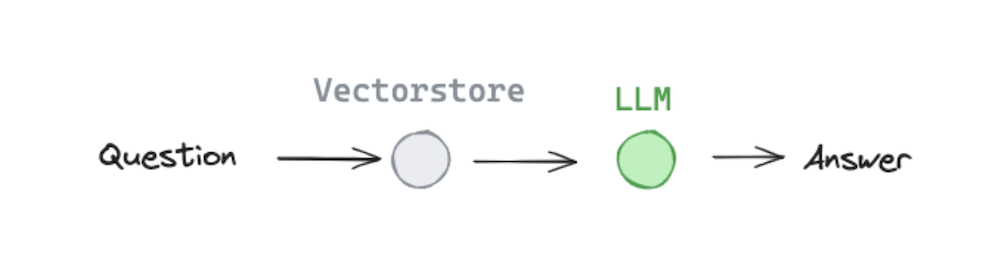

### RAG Agent: LLM-defined control flow

#### Generic agent

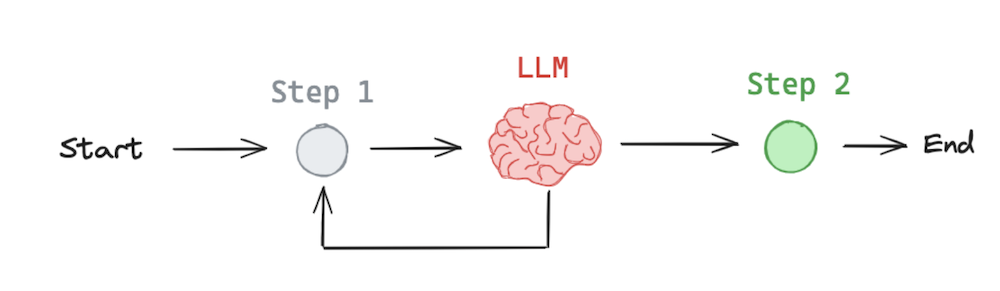

#### RAG Agent ([Corrective RAG](https://arxiv.org/abs/2401.15884))

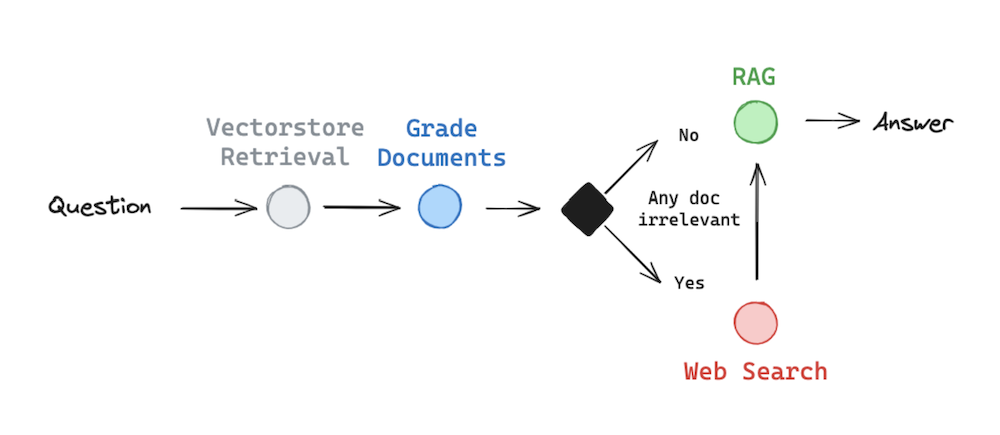

## Demo RAG: Pandas documentation

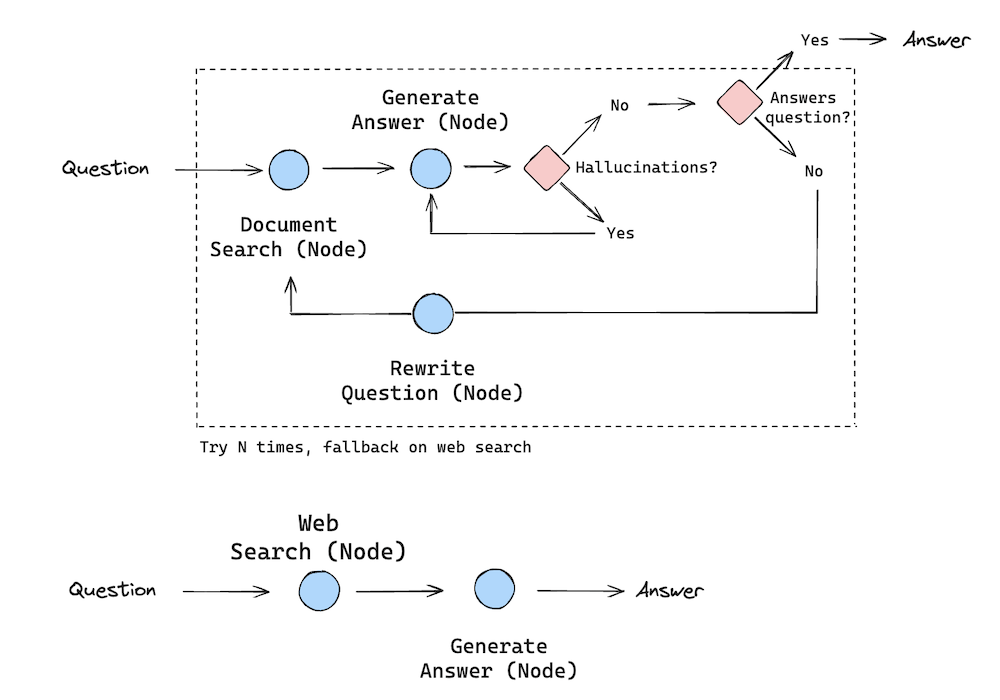

## Set up environment

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY:  ········
ANTHROPIC_API_KEY:  ········
TAVILY_API_KEY:  ········


In [2]:
_set_env("LANGCHAIN_API_KEY")

LANGCHAIN_API_KEY:  ········


## Import dependencies

In [3]:
import re
from typing import Annotated, Iterator, Literal, TypedDict

from langchain import hub
from langchain_community.document_loaders import web_base
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage, AIMessage, convert_to_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.retrievers import BaseRetriever
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import END, StateGraph, add_messages
from langgraph.checkpoint import MemorySaver

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Set up model, retriever & tools

In [4]:
SOURCE_URLS = [
    'https://pandas.pydata.org/docs/user_guide/indexing.html',
    'https://pandas.pydata.org/docs/user_guide/groupby.html',
    'https://pandas.pydata.org/docs/user_guide/merging.html'
]

NEWLINE_RE = re.compile("\n+")

class PandasDocsLoader(web_base.WebBaseLoader):
    def lazy_load(self) -> Iterator[Document]:
        """Lazy load text from the url(s) in web_path."""
        for path in self.web_paths:
            soup = self._scrape(path, bs_kwargs=self.bs_kwargs)
            text = soup.get_text(**self.bs_get_text_kwargs)
            text = NEWLINE_RE.sub("\n", text)     
            metadata = web_base._build_metadata(soup, path)
            yield Document(page_content=text, metadata=metadata)


def prepare_documents(urls: list[str]) -> list[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        separators=[
            r"In \[[0-9]+\]",
            r"\n+",
            r"\s+"
        ],
        is_separator_regex=True,
        chunk_size=1000
    )
    docs = [PandasDocsLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    return text_splitter.split_documents(docs_list)


def get_retriever() -> BaseRetriever:
    documents = prepare_documents(SOURCE_URLS)
    vectorstore = Chroma.from_documents(
        documents=documents,
        collection_name="pandas-rag-chroma",
        embedding=OpenAIEmbeddings(),
    )
    retriever = vectorstore.as_retriever()
    return retriever

In [5]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)
retriever = get_retriever()
tavily_search_tool = TavilySearchResults(max_results=3)

## Set up graph state

In [6]:
class GraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    question: str
    documents: list[Document]
    candidate_answer: str
    retries: int
    web_fallback: bool


class GraphConfig(TypedDict):
    max_retries: int

## Set up graph nodes

### Document search

In [7]:
MAX_RETRIES = 3
VERBOSE = True

In [8]:
def document_search(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if VERBOSE:
        print("---RETRIEVE---")

    question = convert_to_messages(state["messages"])[-1].content

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "web_fallback": True}

### Generate answer

In [9]:
RAG_PROMPT: ChatPromptTemplate = hub.pull("rlm/rag-prompt")


def generate(state: GraphState, config):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if VERBOSE:
        print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)
    web_fallback = state["web_fallback"]

    rag_chain = RAG_PROMPT | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": documents, "question": question})

    state_update = {"retries": retries + 1, "candidate_answer": generation}
    if retries >= max_retries and web_fallback:
        state_update["web_fallback"] = False
    return state_update

### Rewrite question

In [10]:
QUERY_REWRITER_SYSTEM = (
"""
You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
Look at the input and try to reason about the underlying semantic intent / meaning.
"""
)

QUERY_REWRITER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", QUERY_REWRITER_SYSTEM),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

def transform_query(state: GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    if VERBOSE:
        print("---TRANSFORM QUERY---")

    question = state["question"]

    # Re-write question
    query_rewriter = QUERY_REWRITER_PROMPT | llm | StrOutputParser()
    better_question = query_rewriter.invoke({"question": question})
    return {"question": better_question}

### Web search

In [11]:
def web_search(state: GraphState):
    if VERBOSE:
        print("---RUNNING WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]
    search_results = tavily_search_tool.invoke(question)
    search_content = "\n".join([d["content"] for d in search_results])
    documents.append(Document(page_content=search_content, metadata={"source": "websearch"}))
    return {"documents": documents}

### Finalize response

In [12]:
def finalize_response(state: GraphState):
    if VERBOSE:
        print("---FINALIZING THE RESPONSE---")

    return {"messages": [AIMessage(content=state["candidate_answer"])]}

## Set up edges

### Grade answer

* Check hallucinations
* Check answer relevance 

In [13]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


HALLUCINATION_GRADER_SYSTEM = (
"""
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no', where 'yes' means that the answer is grounded in / supported by the set of facts.

IF the generation includes code examples, make sure those examples are FULLY present in the set of facts, otherwise always return score 'no'.
"""
)

HALLUCINATION_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", HALLUCINATION_GRADER_SYSTEM),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


ANSWER_GRADER_SYSTEM = (
"""
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no', where 'yes' means that the answer resolves the question.
"""
)

ANSWER_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", ANSWER_GRADER_SYSTEM),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [15]:
def grade_generation_v_documents_and_question(state: GraphState, config) -> Literal["generate", "transform_query", "web_search", "finalize_response"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["candidate_answer"]
    web_fallback = state["web_fallback"]
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)

    if retries >= max_retries:
        return "web_search" if web_fallback else "finalize_response"

    if VERBOSE:
        print("---CHECK HALLUCINATIONS---")

    hallucination_grader = HALLUCINATION_GRADER_PROMPT | llm.with_structured_output(GradeHallucinations)
    hallucination_grade: GradeHallucinations = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # Check hallucination
    if hallucination_grade.binary_score != "yes":
        if VERBOSE:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")

        return "generate"

    if VERBOSE:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")

    # Check question-answering
    answer_grader = ANSWER_GRADER_PROMPT | llm.with_structured_output(GradeAnswer)
    answer_grade: GradeAnswer = answer_grader.invoke({"question": question, "generation": generation})
    if answer_grade.binary_score == "yes":
        if VERBOSE: print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "finalize_response"
    else:
        if VERBOSE: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "transform_query"

## Assemble graph

In [16]:
workflow = StateGraph(GraphState, config_schema=GraphConfig)

# Define the nodes
workflow.add_node("document_search", document_search)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)
workflow.add_node("finalize_response", finalize_response)

# Build graph
workflow.set_entry_point("document_search")
workflow.add_edge("document_search", "generate")
workflow.add_edge("transform_query", "document_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("finalize_response", END)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question
)

# Compile
graph = workflow.compile()

### Visualize graph

In [17]:
from IPython.display import Image, display

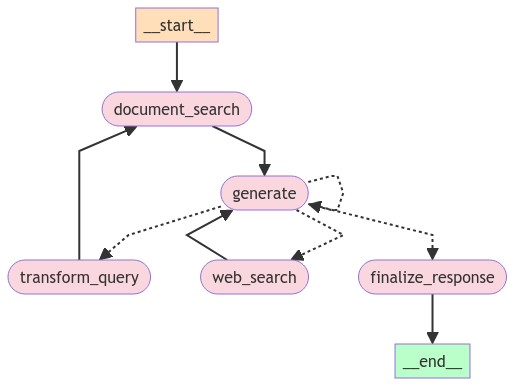

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the graph!

### Streaming

In [21]:
VERBOSE = True
inputs = {"messages": [("human", "how do i calculate sum by groups")]}
for output in graph.stream(inputs):
    print("\n---\n")

---RETRIEVE---

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---

---

---FINALIZING THE RESPONSE---

---



In [22]:
VERBOSE = False
inputs = {"messages": [("human", "how do i calculate sum by groups")]}
for output in graph.stream(inputs):
    print(output)
    print("\n---\n")

{'document_search': {'question': 'how do i calculate sum by groups', 'documents': [Document(page_content='Windowing operations\nTime series / date functionality\nTime deltas\nOptions and settings\nEnhancing performance\nScaling to large datasets\nSparse data structures\nFrequently Asked Questions (FAQ)\nCookbook\nUser Guide\nGroup by:...\nGroup by: split-apply-combine#\nBy “group by” we are referring to a process involving one or more of the following\nsteps:\nSplitting the data into groups based on some criteria.\nApplying a function to each group independently.\nCombining the results into a data structure.\nOut of these, the split step is the most straightforward. In the apply step, we\nmight wish to do one of the following:\nAggregation: compute a summary statistic (or statistics) for each\ngroup. Some examples:\nCompute group sums or means.\nCompute group sizes / counts.\nTransformation: perform some group-specific computations and return a\nlike-indexed object. Some examples:\nSta

In [23]:
VERBOSE = False
inputs = {"messages": [("human", "how do i calculate sum by groups")]}
async for event in graph.astream_events(inputs, version="v2"):
    if event["event"] == "on_chat_model_stream":
        event["data"]["chunk"].pretty_print()

/Users/vadymbarda/.virtualenvs/pandas-rag-langgraph/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


============================ Aimessagechunk Message ============================

To
============================ Aimessagechunk Message ============================

 calculate
============================ Aimessagechunk Message ============================

 sum
============================ Aimessagechunk Message ============================

 by
============================ Aimessagechunk Message ============================

 groups
============================ Aimessagechunk Message ============================

 in
============================ Aimessagechunk Message ============================

 pandas, you can
============================ Aimessagechunk Message ============================

 use the group
============================ Aimessagechunk Message ============================

by() function
============================ Aimessagechunk Message ============================

 followe
============================ Aimessagechunk Message ============================

d by the

#### Query with a fallback

In [24]:
VERBOSE = True
inputs = {"messages": [("human", "how do i convert a column into dummies")]}
for output in graph.stream(inputs, {"configurable": {"max_retries": 1}}):
    print("\n---\n")

---RETRIEVE---

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---

---

---GENERATE---

---

---RUNNING WEB SEARCH---

---

---GENERATE---

---

---FINALIZING THE RESPONSE---

---



### Interrupts: human-in-the-loop

In [25]:
checkpointer = MemorySaver()

In [26]:
graph_with_memory = workflow.compile(checkpointer=checkpointer)

In [27]:
thread_config = {"configurable": {"thread_id": 1}}

In [28]:
VERBOSE = False
inputs = {"messages": [("human", "how do i convert a column into dummies")]}
for output in graph_with_memory.stream(inputs, thread_config, interrupt_before=["generate"]):
    print(output)
    print("\n---\n")

{'document_search': {'question': 'how do i convert a column into dummies', 'documents': [Document(page_content='naturally to multiple columns of mixed type and different\nsources. This can be useful as an intermediate categorical-like step\nin processing, when the relationships between the group rows are more\nimportant than their content, or as input to an algorithm which only\naccepts the integer encoding. (For more information about support in\npandas for full categorical data, see the Categorical\nintroduction and the\nAPI documentation.)', metadata={'language': 'en', 'source': 'https://pandas.pydata.org/docs/user_guide/groupby.html', 'title': 'Group by: split-apply-combine — pandas 2.2.2 documentation'}), Document(page_content="In [7]: df[['B', 'A']] = df[['A', 'B']]\nIn [8]: df\nOut[8]: \n                   A         B         C         D\n2000-01-01 -0.282863  0.469112 -1.509059 -1.135632\n2000-01-02 -0.173215  1.212112  0.119209 -1.044236\n2000-01-03 -2.104569 -0.861849 -0.4949

#### Update the document to contain a correct answer

In [29]:
documents = output["document_search"]["documents"]
documents[0].page_content = "to convert a column into dummies use pd.get_dummies"

In [30]:
graph_with_memory.update_state(thread_config, {"documents": documents}, as_node="document_search")

{'configurable': {'thread_id': 1,
  'thread_ts': '1ef34076-35e0-68c8-8002-8bb7ba9f9629'}}

#### Continue streaming from the interrupt

In [31]:
VERBOSE = False
for output in graph_with_memory.stream(None, thread_config):
    print(output)
    print("\n---\n")

{'generate': {'candidate_answer': 'To convert a column into dummies in pandas, you can use the pd.get_dummies() function. This function will create binary columns for each unique value in the specified column. The resulting dummy variables will be added to your DataFrame, allowing you to use them for further analysis or modeling.', 'retries': 0}}

---

{'finalize_response': {'messages': [AIMessage(content='To convert a column into dummies in pandas, you can use the pd.get_dummies() function. This function will create binary columns for each unique value in the specified column. The resulting dummy variables will be added to your DataFrame, allowing you to use them for further analysis or modeling.')]}}

---



## LangGraph Cloud

In [32]:
from langgraph_sdk import get_client

client = get_client(url="https://pandas-rag-c42e716a7dc35d438612c0a7cac2aa42-ffoprvkqsa-uc.a.run.app/")

### Streaming

In [33]:
thread = await client.threads.create()

In [34]:
inputs = {"messages": [("human", "how do i calculate sum by groups")]}
async for output in client.runs.stream(thread["thread_id"], "agent", input=inputs):
    print(output)
    print("\n---\n")

StreamPart(event='metadata', data={'run_id': '1ef3407c-a485-6c6e-927f-57309eb45c48'})

---

StreamPart(event='values', data={'messages': [{'content': 'how do i calculate sum by groups', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cf2fbb38-1d2d-40f0-8b0c-64ce0df80c6e', 'example': False}]})

---

StreamPart(event='values', data={'messages': [{'content': 'how do i calculate sum by groups', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cf2fbb38-1d2d-40f0-8b0c-64ce0df80c6e', 'example': False}], 'question': 'how do i calculate sum by groups', 'documents': [{'page_content': 'Windowing operations\nTime series / date functionality\nTime deltas\nOptions and settings\nEnhancing performance\nScaling to large datasets\nSparse data structures\nFrequently Asked Questions (FAQ)\nCookbook\nUser Guide\nGroup by:...\nGroup by: split-apply-combine#\nBy “group by” we are referring to a process involving one or more of the

### Thread state

In [34]:
state = await client.threads.get_state(thread["thread_id"])

In [37]:
for message in convert_to_messages(state["values"]["messages"]):
    message.pretty_print()

================================ Human Message =================================

how do i calculate sum by groups
================================== Ai Message ==================================

To calculate sum by groups in pandas, you can use the groupby() function followed by the sum() method. For example, if you have a DataFrame called 'df' with a column 'group' and a column 'value', you can calculate the sum of 'value' for each group like this: df.groupby('group')['value'].sum(). This will return a Series with the group names as the index and the sum of values for each group.


## Sign up for LangGraph Cloud

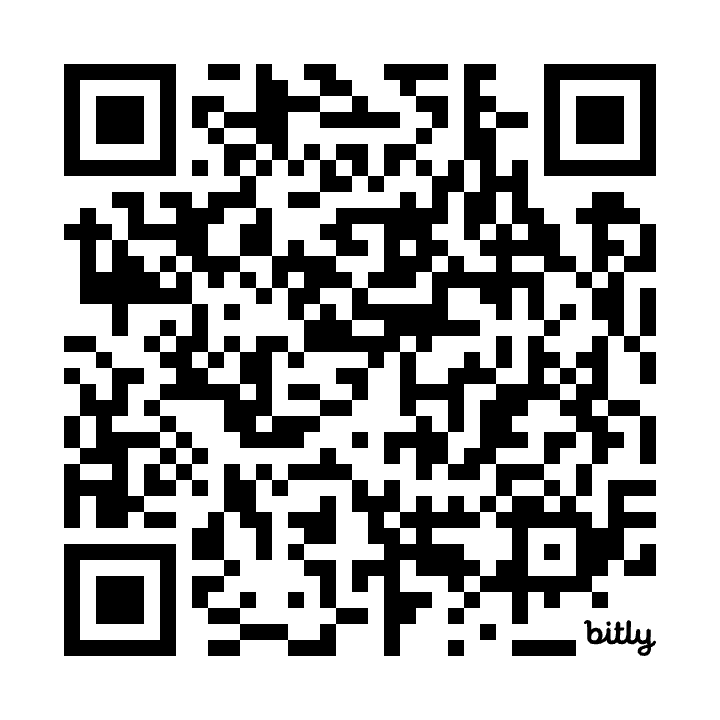